# 3D Voxel VAE
This is rough work going through:
1. Making 3D voxel VAE
2. Generating all 90 degree rotations for voxels
3. New voxel dataloader with 90 degree rotation augmentation
4. 3D AVAE - Implementing a 3D affine transform and its inverse for a VAE
5. 3D AVAE all 90 optimization - tests all 24 orientations 
6. training on all 90 augmneted data, and with all_90 put


#### Other:
Voxel vae https://arxiv.org/pdf/1608.04236.pdf
when its time for fully differentiable https://nv-tlabs.github.io/DIB-R/files/diff_shader.pdf

In [1]:
import os
import math
import random
import pickle
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import StepLR

import kaolin as kal
from kaolin.datasets import ModelNet, ModelNetVoxels

# from models import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
class VAE(nn.Module):
    """3d VAE. Force sigma=1"""
    def __init__(self, latent_size=8, img_size=32):
        super(VAE, self).__init__()
        self.latent_size = latent_size
        self.img_size = img_size
        self.linear_size = int(8*(img_size/8)**3)

        self.elu = nn.ELU()
        self.enc_conv1 = nn.Conv3d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.enc_conv2 = nn.Conv3d(16, 16, kernel_size=5, stride=2, padding=2, bias=False)
        self.enc_conv3 = nn.Conv3d(16, 32, kernel_size=5, stride=2, padding=2, bias=False)
        self.enc_conv4 = nn.Conv3d(32, 8, kernel_size=3, stride=2, padding=1, bias=True)
        self.enc_bn1 = nn.BatchNorm3d(16)
        self.enc_bn2 = nn.BatchNorm3d(16)
        self.enc_bn3 = nn.BatchNorm3d(32)

        self.dec_conv1 = nn.ConvTranspose3d(8, 32, kernel_size=3, stride=2, padding=1,  output_padding=1, bias=False)
        self.dec_conv2 = nn.ConvTranspose3d(32, 16, kernel_size=5, stride=2, padding=2,  output_padding=1, bias=False)
        self.dec_conv3 = nn.ConvTranspose3d(16, 16, kernel_size=5, stride=2, padding=2,  output_padding=1, bias=False)
        self.dec_conv4 = nn.ConvTranspose3d(16, 1, kernel_size=3, stride=1, padding=1,  output_padding=0, bias=True)
        self.dec_bn1 = nn.BatchNorm3d(32)
        self.dec_bn2 = nn.BatchNorm3d(16)
        self.dec_bn3 = nn.BatchNorm3d(16)

        self.fc_enc = nn.Linear(self.linear_size, self.latent_size)
        self.fc_dec = nn.Linear(self.latent_size, self.linear_size)

    def forward(self, x, deterministic=False):
        mu = self.encode(x)
        z = self.reparameterize(mu, deterministic)
        recon_x = self.decode(z)
        return recon_x, mu

    def encode(self, x):
        x = self.elu(self.enc_bn1(self.enc_conv1(x)))
        x = self.elu(self.enc_bn2(self.enc_conv2(x)))
        x = self.elu(self.enc_bn3(self.enc_conv3(x)))
        x = self.enc_conv4(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_enc(x)
        return mu

    def decode(self, x):
        x = self.fc_dec(x)
        x = x.view((-1, 8, int(self.img_size/8), int(self.img_size/8), int(self.img_size/8)))
        x = self.elu(self.dec_bn1(self.dec_conv1(x)))
        x = self.elu(self.dec_bn2(self.dec_conv2(x)))
        x = self.elu(self.dec_bn3(self.dec_conv3(x)))
        x = self.dec_conv4(x)
        return torch.sigmoid(x)

    def reparameterize(self, mu, deterministic=False):
        if deterministic: 
            return mu
        else:
            return mu.add_(torch.randn_like(mu))

In [3]:
def loss_function(recon_x, x, mu):
    BCE = F.binary_cross_entropy(recon_x.squeeze(), x.squeeze(), reduction='sum')
    KLD = -0.5 * torch.sum(1 + 0 - mu.pow(2) - 1)#logvar.exp())
    return BCE + KLD

def train(epoch, print_freq=5):
    model.train()
    train_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        data = batch['data']['32'].to(device).unsqueeze(1)
        optimizer.zero_grad()
        recon_batch, mu = model(data)
        loss = loss_function(recon_batch, data, mu)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % print_freq == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(train_loader.dataset)))

def val(epoch, print_freq=5):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
                data = batch['data']['32'].to(device).unsqueeze(1)
                recon_batch, mu = model(data)
                val_loss += loss_function(recon_batch, data, mu).item()
        val_loss /= len(val_loader.dataset)
    if epoch % print_freq == 0:
        print('====> Val set loss: {:.4f}'.format(val_loss))
        
def plot_recon_voxels(batch, model, nsamples=4, voxel_threshold=.5):
    x = batch['data']['32'].to(device)[:nsamples, :, :, :].unsqueeze(1)
    recon_x, mu = model(x)
    recon_x = recon_x > voxel_threshold
    x, recon_x = x.squeeze(), recon_x.squeeze()
    labels = batch['attributes']['category'][:nsamples]
    
    nrows, ncols = nsamples, 2
    fig = plt.figure(figsize=(8, 3*nsamples))
    for idx in range(0, x.size(0), 1):
        label = labels[idx]
        ax = fig.add_subplot(nrows, ncols, 2*idx + 1, projection='3d')
        ax.voxels(x[idx, :, :, :], facecolors='blue', edgecolor='k')
        ax.axis('off')
        ax.set_title(labels[idx])
        
        ax = fig.add_subplot(nrows, ncols, 2*idx + 2, projection='3d')
        ax.voxels(recon_x[idx, :, :, :], facecolors='blue', edgecolor='k')
        ax.axis('off')

## Serious overfit

In [4]:
modelnet_path = './data/ModelNet10'
categories = ['chair']
device = 'cuda:0'

trainset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='train', device=device)
valset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='test', device=device)
trainset.names = trainset.names[:4]
valset.names = valset.names[:256]

print('len(trainset)', len(trainset))
train_loader = DataLoader(trainset, batch_size=2)
val_loader = DataLoader(valset, batch_size=256)

converting to voxels to resolution 32: 100%|██████████| 100/100 [00:00<00:00, 28121.38it/s]

len(trainset) 4


In [5]:
model = VAE().to(device)

epochs = 400
optimizer = optim.Adam(model.parameters(), lr=3e-3)
scheduler = StepLR(optimizer, step_size=int(epochs/3), gamma=0.2)

for epoch in range(1, epochs + 1):
    train(epoch, print_freq=50)
    val(epoch, print_freq=50)
    scheduler.step()

====> Epoch: 50 Average loss: 687.9311
====> Val set loss: 12323.6600
====> Epoch: 100 Average loss: 210.6771
====> Val set loss: 18111.0600
====> Epoch: 150 Average loss: 94.4639
====> Val set loss: 20630.0750
====> Epoch: 200 Average loss: 85.0582
====> Val set loss: 21672.5050
====> Epoch: 250 Average loss: 123.2234
====> Val set loss: 19922.6825
====> Epoch: 300 Average loss: 89.7382
====> Val set loss: 21346.2175
====> Epoch: 350 Average loss: 76.2556
====> Val set loss: 21774.7700
====> Epoch: 400 Average loss: 65.0116
====> Val set loss: 21873.0150


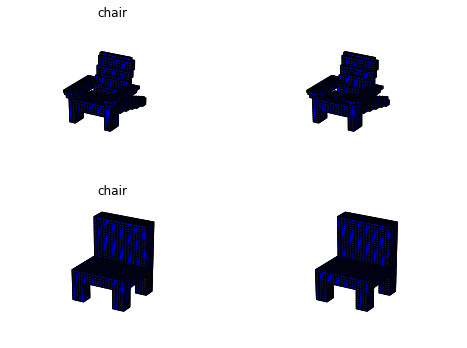

In [6]:
batch = next(iter(train_loader))
plot_recon_voxels(batch, model, nsamples=2, voxel_threshold=.3)

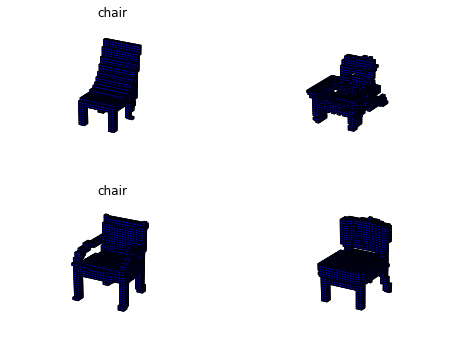

In [7]:
batch = next(iter(val_loader))
plot_recon_voxels(batch, model, nsamples=2, voxel_threshold=.3)

## Rotating 3d - 90 degree


In [8]:
modelnet_path = './data/ModelNet10'
categories = ['chair']
device = 'cuda:0'

trainset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='train', device=device)
valset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='test', device=device)
train_loader = DataLoader(trainset, batch_size=2)
val_loader = DataLoader(valset, batch_size=256)

converting to voxels to resolution 32: 100%|██████████| 100/100 [00:00<00:00, 28942.20it/s]


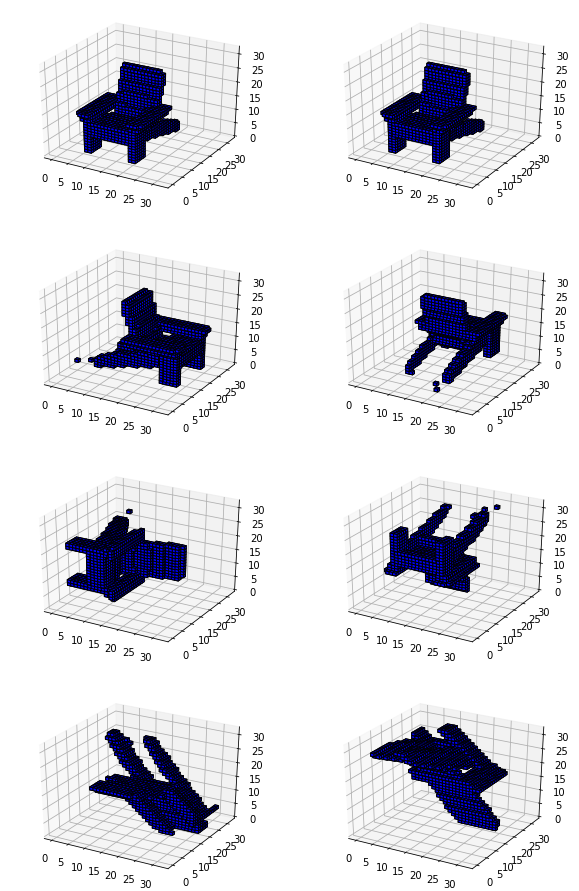

In [9]:
def show_rotations(x, rot_mat_list):
    nrows, ncols = int(len(rot_mat_list)/2), 2
    fig = plt.figure(figsize=(10, nrows*4))
    for idx in range(0, nrows*ncols, 1):
        rotated_x = affine_transform(x, rot_mat_list[idx].to(device))    
        rotated_x = rotated_x > .1
        ax = fig.add_subplot(nrows, ncols, idx + 1, projection='3d')
        ax.voxels(rotated_x.squeeze(), facecolors='blue', edgecolor='k')

def rotate_90_mat(theta, axis='x'):
    theta = theta*math.pi / 180
    if axis == 'x':
        rot_mat = torch.FloatTensor([[1, 0, 0],
                                [0, math.cos(theta), -1*math.sin(theta)],
                                [0, math.sin(theta), math.cos(theta)]])
    elif axis == 'y':
        rot_mat = torch.FloatTensor([[math.cos(theta), 0, math.sin(theta)],
                                [0, 1, 0],
                                [-1*math.sin(theta), 0, math.cos(theta)]])
    elif axis == 'z':
        rot_mat = torch.FloatTensor([[math.cos(theta), -1*math.sin(theta), 0],
                                [math.sin(theta), math.cos(theta), 0],
                                [1, 0, 1]])
    affine_mat = torch.zeros(3, 4)
    affine_mat[:, :3] = rot_mat
    return affine_mat.unsqueeze(0)

def affine_transform(x, affine_params, padding_mode='zeros'):
    grid = F.affine_grid(affine_params, x.size(), align_corners=False).cuda()
    x = F.grid_sample(x, grid, padding_mode=padding_mode, align_corners=False)
    return x


identity = torch.FloatTensor([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, 0]]).unsqueeze(0)
rot_mat_list = [identity,
                rotate_90_mat(theta=0, axis='x'), 
                rotate_90_mat(theta=90, axis='x'), 
                rotate_90_mat(theta=180, axis='x'),
                rotate_90_mat(theta=90, axis='y'), 
                rotate_90_mat(theta=180, axis='y'), 
                rotate_90_mat(theta=90, axis='z'),
                rotate_90_mat(theta=180, axis='z')]        
        
batch = next(iter(train_loader))
x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0)
show_rotations(x, rot_mat_list)

## 3D AVAE

In [4]:
# Use only 90 as a flag when creating the model, or only when optimizing?
# where to add the flexibility?

class AVAE3d(nn.Module):
    def __init__(self, VAE, opt_method='all_90_rot'):
        super(AVAE3d, self).__init__()
        self.VAE = VAE
        self.opt_method = opt_method
        self.rotation_only = True
        if self.opt_method == 'all_90_rot':
            self.all_90_rot = self.get_all_rot_mat()
            
    def get_all_rot_mat(self):
        def rot90_x(mat): return torch.mm(torch.FloatTensor([[1, 0, 0], [0, 0, -1], [0, 1, 0]]), mat)
        def rot90_y(mat): return torch.mm(torch.FloatTensor([[0, 0, 1], [0, 1, 0], [-1, 0, 0]]), mat)
        mat = torch.zeros(3, 4)
        mat[:, :3] = torch.FloatTensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
        all_rotations = []
        for cycle in range(2):
            for step in range(3):
                mat[:, :3] = rot90_x(mat[:, :3])
                all_rotations.append(mat.clone())
                for i in range(3):
                    mat[:, :3] = rot90_y(mat[:, :3])
                    all_rotations.append(mat.clone())
            mat[:, :3] = rot90_x(rot90_y(rot90_x(mat[:, :3])))
        return torch.stack(all_rotations)
            
        
    def affine(self, x, affine_params, padding_mode='zeros'):
        grid = F.affine_grid(affine_params, x.size(), align_corners=False).to(x.device)
        x = F.grid_sample(x, grid, padding_mode=padding_mode, align_corners=False)
        return x
    
    def affine_inv(self, x, affine_params, padding_mode='zeros'):
        inv_affine_params = torch.FloatTensor(affine_params.size()).fill_(0).to(x.device)
        if self.rotation_only: # inverse is transpose
            inv_affine_params[:, :, :3] = torch.transpose(affine_params[:, :, :3], 1, 2) 
        else:
            pass
        grid = F.affine_grid(inv_affine_params, x.size(), align_corners=False).to(x.device)
        x = F.grid_sample(x, grid, padding_mode=padding_mode, align_corners=False)
        return x
    
    
    def forward(self, x, deterministic=False, opt_method=None):
        # ??? this opt_method overrides the one when creating the model, 
#         if opt_method==None:
        opt_method = self.opt_method
        if opt_method==None: # affine is identity
            affine_params = torch.zeros(3, 4).to(x.device)
            affine_params[:, :3] = torch.FloatTensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
            affine_params = affine_params.unsqueeze(0).repeat(x.size(0), 1, 1).to(x.device)
            recon_x, mu = self.affine_forward(x, affine_params=affine_params, deterministic=deterministic)
        elif opt_method=='all_90_rot':
            recon_x, mu, loss, affine_params = self.forward_best_90_rot(x, deterministic=True)
            # Shouldn't need this:
            recon_x, mu = self.affine_forward(x, affine_params=affine_params, deterministic=False)
        return {'recon_x':recon_x, 
                'mu': mu,
                'affine_params': affine_params}
        
        
    def affine_forward(self, x, affine_params=None, deterministic=False):
        x_affine = self.affine(x, affine_params)
        mu = self.VAE.encode(x_affine)
        z = self.VAE.reparameterize(mu, deterministic)
        recon_x = self.VAE.decode(z)
        recon_x = self.affine_inv(recon_x, affine_params)
        return recon_x, mu

    
    def forward_best_90_rot(self, x, deterministic=True):
        """ Try all 24 rotations.
        
        Loss for all afffine params and imgs in parallel. 
        Duplicate imgs & params since can only apply one affine per img.
        returns: loss, affine_params(3x4)
        """                                
        with torch.no_grad():
            affine_params = self.all_90_rot.clone().detach().to(x.device) # be safe
            bs, ch, _, _, _ = x.size()
            n_affine, _, _ = affine_params.size()
            x_repeated = x.repeat(n_affine, 1, 1, 1, 1)
            affine_params_repeat = affine_params.repeat_interleave(bs).view(bs*n_affine, 3, 4).to(x.device)
                        
            recon_x, mu = self.affine_forward(x_repeated, affine_params=affine_params_repeat, deterministic=deterministic)
            
            loss = self.vae_loss_unreduced((recon_x, mu), x_repeated)
            loss = loss.view(n_affine, bs, 1)
            best_loss, best_param_idx = torch.min(loss, dim=0)

            # select the params, recon_x, mu corresponding to lowest loss
            mu = mu.view(n_affine, bs, -1)
            affine_params_repeat = affine_params_repeat.view(n_affine, bs, 3, 4)
            recon_x = recon_x.view(n_affine, bs, 1, recon_x.size(-3), recon_x.size(-2), recon_x.size(-1))
            
            recon_x_best = recon_x[best_param_idx.squeeze(), torch.arange(bs), :, :, :, :]
            mu_best = mu[best_param_idx.squeeze(), torch.arange(bs), :]
            best_affine_params = affine_params_repeat[best_param_idx.squeeze(), torch.arange(bs), :, :]

        return recon_x_best, mu_best, best_loss, best_affine_params
            
            
    def vae_loss_unreduced(self, output, target, KLD_weight=1):
        recon_x, mu  = output
        BCE = F.binary_cross_entropy(recon_x.squeeze(), target.squeeze(), reduction='none')
        BCE = torch.sum(BCE, dim=(1, 2, 3))
        KLD = -0.5 * torch.sum(1 + 0 - mu.pow(2) - 1)
        return BCE + KLD_weight*KLD

## DataLoaders
* Must augment with 3D rotations, and record these rotations

In [5]:
class TransformedModelNetVoxels(ModelNetVoxels):
    def __init__(self, modelnet_path, transform_type='none', categories=['chair'], device='cuda', split='train', resolutions=[32]):
        super(TransformedModelNetVoxels, self).__init__(modelnet_path, categories=categories, resolutions=resolutions, split=split, device=device)
        self.transform_type = transform_type

        def get_all_rot_mat():
            def rot90_x(mat): return torch.mm(torch.FloatTensor([[1, 0, 0], [0, 0, -1], [0, 1, 0]]), mat)
            def rot90_y(mat): return torch.mm(torch.FloatTensor([[0, 0, 1], [0, 1, 0], [-1, 0, 0]]), mat)
            mat = torch.zeros(3, 4)
            mat[:, :3] = torch.FloatTensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
            all_rotations = []
            for cycle in range(2):
                for step in range(3):
                    mat[:, :3] = rot90_x(mat[:, :3])
                    all_rotations.append(mat.clone())
                    for i in range(3):
                        mat[:, :3] = rot90_y(mat[:, :3])
                        all_rotations.append(mat.clone())
                mat[:, :3] = rot90_x(rot90_y(rot90_x(mat[:, :3])))
            return torch.stack(all_rotations)
        self.all_90_rot = get_all_rot_mat()

    
    def affine(self, x, affine_params, padding_mode='zeros'):
        grid = F.affine_grid(affine_params, x.size(), align_corners=False).to(x.device)
        x = F.grid_sample(x, grid, padding_mode=padding_mode, align_corners=False)
        return x
    
    def random_90(self, x):
        affine_params = self.all_90_rot[random.randint(0, 23), :, :]
        x = self.affine(x, affine_params.unsqueeze(0), padding_mode='zeros')
        return x, affine_params

    def __len__(self):
        return len(self.names)

    def __getitem__(self, index):
        """Returns the item at index idx. """
        data = dict()
        attributes = dict()
        name = self.names[index]

        for res in self.params['resolutions']:
            data[str(res)] = self.cache_transforms[res](name)
        attributes['name'] = name
        attributes['category'] = self.categories[self.cat_idxs[index]]
        
        if self.transform_type == 'random_90_rot':
            data[str(res)], attributes['affine_params'] = self.random_90(data[str(res)].unsqueeze(0).unsqueeze(0))
            data[str(res)] = data[str(res)].squeeze()
        return {'data': data, 'attributes': attributes}        

## Training 3d AVAE

In [6]:
def loss_function(recon_x, x, mu):
    BCE = F.binary_cross_entropy(recon_x.squeeze(), x.squeeze(), reduction='sum')
    KLD = -0.5 * torch.sum(1 + 0 - mu.pow(2) - 1)
    return BCE + KLD

def train(epoch, print_freq=5):
    model.train()
    train_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        x = batch['data']['32'].to(device).unsqueeze(1)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_function(output['recon_x'], x, output['mu'])
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % print_freq == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(train_loader.dataset)))

def val(epoch, print_freq=5):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
                x = batch['data']['32'].to(device).unsqueeze(1)
                output = model(x)
                val_loss += loss_function(output['recon_x'], x, output['mu']).item()
                # !!!!  log output['affine_params']
        val_loss /= len(val_loader.dataset)
    if epoch % print_freq == 0:
        print('====> Val set loss: {:.4f}'.format(val_loss))
        
def plot_recon_voxels(batch, model, nsamples=4, voxel_threshold=.5):
    x = batch['data']['32'].to(device)[:nsamples, :, :, :].unsqueeze(1)
    stuff = model(x, deterministic=False, opt_method=None)
    recon_x = stuff['recon_x']
    recon_x = recon_x > voxel_threshold
    x, recon_x = x.squeeze(), recon_x.squeeze()
    labels = batch['attributes']['category'][:nsamples]
    
    nrows, ncols = nsamples, 2
    fig = plt.figure(figsize=(8, 3*nsamples))
    for idx in range(0, x.size(0), 1):
        label = labels[idx]
        ax = fig.add_subplot(nrows, ncols, 2*idx + 1, projection='3d')
        ax.voxels(x[idx, :, :, :], facecolors='blue', edgecolor='k')
        ax.axis('off')
        ax.set_title(labels[idx])
        
        ax = fig.add_subplot(nrows, ncols, 2*idx + 2, projection='3d')
        ax.voxels(recon_x[idx, :, :, :], facecolors='blue', edgecolor='k')
        ax.axis('off')

In [7]:
modelnet_path = './data/ModelNet10'
categories = ['chair']
device = 'cuda:0'
bs = 30

trainset = TransformedModelNetVoxels(modelnet_path, transform_type='random_90_rot', categories=categories, 
                                     resolutions=[32], split='train', device=device)
valset = TransformedModelNetVoxels(modelnet_path, transform_type='random_90_rot', categories=categories, 
                                   resolutions=[32], split='test', device=device)
train_loader = DataLoader(trainset, batch_size=bs)
val_loader = DataLoader(valset, batch_size=2*bs)

converting to voxels to resolution 32: 100%|██████████| 100/100 [00:00<00:00, 66397.09it/s]


In [ ]:
model = AVAE3d(VAE=VAE(latent_size=8, img_size=32), opt_method='all_90_rot').to(device)

epochs = 10
optimizer = optim.Adam(model.parameters(), lr=3e-3)
scheduler = StepLR(optimizer, step_size=int(epochs/3), gamma=0.2)

for epoch in range(1, epochs + 1):
    train(epoch, print_freq=1)
    val(epoch, print_freq=1)
    scheduler.step()

====> Epoch: 1 Average loss: 11412.2530
====> Val set loss: 11158.7309
====> Epoch: 2 Average loss: 10621.7488
====> Val set loss: 11019.1725
====> Epoch: 3 Average loss: 10866.1185
====> Val set loss: 11666.4428
====> Epoch: 4 Average loss: 10508.2221
====> Val set loss: 11828.8563
====> Epoch: 5 Average loss: 10618.1238
====> Val set loss: 11431.4044


In [116]:
modelnet_path = './data/ModelNet10'
categories = ['chair']
device = 'cuda:0'
bs = 32

trainset = TransformedModelNetVoxels(modelnet_path, transform_type='random_90_rot', categories=categories, 
                                     resolutions=[32], split='train', device=device)
valset = TransformedModelNetVoxels(modelnet_path, transform_type='random_90_rot', categories=categories, 
                                   resolutions=[32], split='test', device=device)
train_loader = DataLoader(trainset, batch_size=bs)
val_loader = DataLoader(valset, batch_size=2*bs)

converting to voxels to resolution 32: 100%|██████████| 100/100 [00:00<00:00, 67098.13it/s]


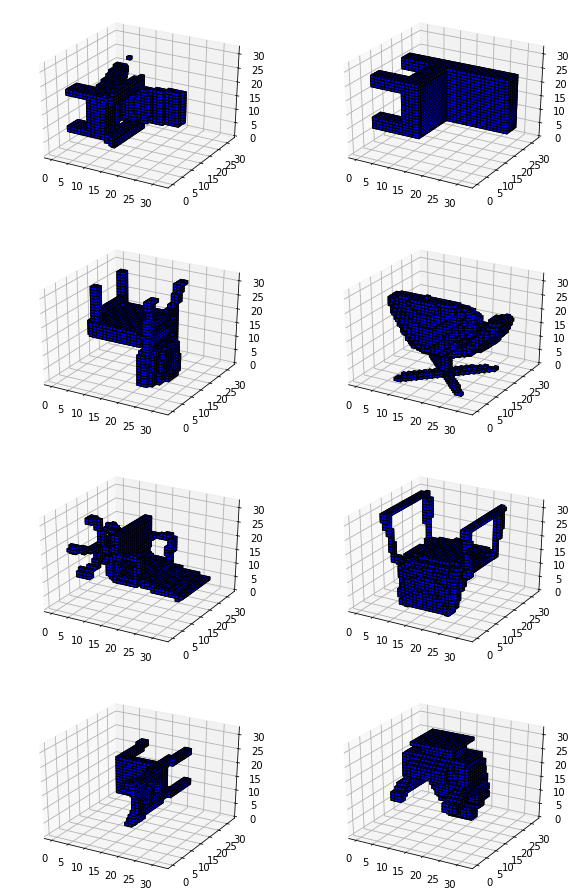

In [83]:
batch = next(iter(train_loader))
x = batch['data']['32'][:8, :, :, :].to(device)

nrows, ncols = 4, 2
fig = plt.figure(figsize=(10, nrows*4))
for idx in range(0, nrows*ncols, 1):
    x = x > .3
    ax = fig.add_subplot(nrows, ncols, idx + 1, projection='3d')
    ax.voxels(x[idx, :, :, :].squeeze(), facecolors='blue', edgecolor='k')

## Random stuff

##### Check folding in affine params doesn't mix dims incorrectly

In [114]:
x = torch.FloatTensor([0, 1, 2, 3, 4]).unsqueeze(1).unsqueeze(1).repeat(1, 2, 2)
print(x.size())
print(x[0, :, :])
print(x[1:3, :, :])

params = torch.FloatTensor([.1, 1, 10]).unsqueeze(1).repeat(1, 3)
print(params.size())
print(params[0])
print(params)

torch.Size([5, 2, 2])
tensor([[0., 0.],
        [0., 0.]])
tensor([[[1., 1.],
         [1., 1.]],

        [[2., 2.],
         [2., 2.]]])
torch.Size([3, 3])
tensor([0.1000, 0.1000, 0.1000])
tensor([[ 0.1000,  0.1000,  0.1000],
        [ 1.0000,  1.0000,  1.0000],
        [10.0000, 10.0000, 10.0000]])


In [115]:
bs, _, _ = x.size()
n_affine, _ = params.size()
x_repeated = x.repeat(n_affine, 1, 1)
print(x_repeated.size())
print(x_repeated[:2, :, :])
print(params.size())
s = params.size()
params_duplicated = params.repeat_interleave(bs).view(bs, *s)
params_duplicated = params_duplicated.view(bs*n_affine, -1)
print(params_duplicated.size())
print(params_duplicated[:bs+1, :])

torch.Size([15, 2, 2])
tensor([[[0., 0.],
         [0., 0.]],

        [[1., 1.],
         [1., 1.]]])
torch.Size([3, 3])
torch.Size([15, 3])
tensor([[0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000],
        [1.0000, 1.0000, 1.0000]])


In [121]:
out = torch.bmm(x_repeated.view(n_affine*bs, -1).unsqueeze(-1), params_duplicated.unsqueeze(1)).mean(-1).mean(-1)
print(out.size())
print(out[1:3])
print(out[bs+1:bs+3])

out = out.view(n_affine, bs, 1)
print(out.size())
print(out[0, :, :])
print(out[1, :, :])

torch.Size([15])
tensor([0.1000, 0.2000])
tensor([1., 2.])
torch.Size([3, 5, 1])
tensor([[0.0000],
        [0.1000],
        [0.2000],
        [0.3000],
        [0.4000]])
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.]])


#### All 3d 90 degree rotations
https://stackoverflow.com/questions/16452383/how-to-get-all-24-rotations-of-a-3-dimensional-array

In [138]:
def get_all_rot_mat():
    def rot90_x(mat): return torch.mm(torch.FloatTensor([[1, 0, 0], [0, 0, -1], [0, 1, 0]]), mat)
    def rot90_y(mat): return torch.mm(torch.FloatTensor([[0, 0, 1], [0, 1, 0], [-1, 0, 0]]), mat)
    matrix = torch.FloatTensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    all_rotations = []
    for cycle in range(2):
        for step in range(3):
            matrix = rot90_x(matrix)
            all_rotations.append(matrix)
            for i in range(3):
                matrix = rot90_y(matrix)
                all_rotations.append(matrix)
        matrix = rot90_x(rot90_y(rot90_x(matrix)))
    return torch.stack(all_rotations)

stuff = get_all_rot_mat()
print(stuff.size())
stuff

torch.Size([24, 3, 3])


tensor([[[ 1.,  0.,  0.],
         [ 0.,  0., -1.],
         [ 0.,  1.,  0.]],

        [[ 0.,  1.,  0.],
         [ 0.,  0., -1.],
         [-1.,  0.,  0.]],

        [[-1.,  0.,  0.],
         [ 0.,  0., -1.],
         [ 0., -1.,  0.]],

        [[ 0., -1.,  0.],
         [ 0.,  0., -1.],
         [ 1.,  0.,  0.]],

        [[ 0., -1.,  0.],
         [-1.,  0.,  0.],
         [ 0.,  0., -1.]],

        [[ 0.,  0., -1.],
         [-1.,  0.,  0.],
         [ 0.,  1.,  0.]],

        [[ 0.,  1.,  0.],
         [-1.,  0.,  0.],
         [ 0.,  0.,  1.]],

        [[ 0.,  0.,  1.],
         [-1.,  0.,  0.],
         [ 0., -1.,  0.]],

        [[ 0.,  0.,  1.],
         [ 0.,  1.,  0.],
         [-1.,  0.,  0.]],

        [[-1.,  0.,  0.],
         [ 0.,  1.,  0.],
         [ 0.,  0., -1.]],

        [[ 0.,  0., -1.],
         [ 0.,  1.,  0.],
         [ 1.,  0.,  0.]],

        [[ 1.,  0.,  0.],
         [ 0.,  1.,  0.],
         [ 0.,  0.,  1.]],

        [[ 0.,  1.,  0.],
         [ 0.,

In [ ]:
def plot_recon_voxels(batch, model, nsamples=4, voxel_threshold=.5):
    x = batch['data']['32'].to(device)[:nsamples, :, :, :].unsqueeze(1)
    recon_x, mu = model(x)
    recon_x = recon_x > voxel_threshold
    x, recon_x = x.squeeze(), recon_x.squeeze()
    labels = batch['attributes']['category'][:nsamples]
    
    nrows, ncols = nsamples, 2
    fig = plt.figure(figsize=(8, 3*nsamples))
    for idx in range(0, x.size(0), 1):
        label = labels[idx]
        ax = fig.add_subplot(nrows, ncols, 2*idx + 1, projection='3d')
        ax.voxels(x[idx, :, :, :], facecolors='blue', edgecolor='k')
        ax.axis('off')
        ax.set_title(labels[idx])
        
        ax = fig.add_subplot(nrows, ncols, 2*idx + 2, projection='3d')
        ax.voxels(recon_x[idx, :, :, :], facecolors='blue', edgecolor='k')
        ax.axis('off')